In [19]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, precision_recall_curve, average_precision_score, classification_report
from sklearn.datasets import load_iris
from itertools import cycle
import lime
import lime.lime_tabular

In [20]:
df = pd.read_csv("df_arabica_clean.csv")
df.shape

(207, 41)

In [21]:
# Comptage des mentions de chaque pays
country_counts = df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['Country of Origin', 'count']

# Affichage des résultats
print(country_counts)

               Country of Origin  count
0                         Taiwan     61
1                      Guatemala     21
2                       Colombia     19
3                       Honduras     13
4                       Thailand     12
5                       Ethiopia     11
6                         Brazil     10
7                     Costa Rica      8
8                      Nicaragua      7
9                    El Salvador      7
10  Tanzania, United Republic Of      6
11        United States (Hawaii)      5
12                        Mexico      4
13                          Peru      4
14                       Vietnam      4
15                        Uganda      3
16                     Indonesia      3
17                          Laos      3
18                        Panama      2
19                         Kenya      2
20                    Madagascar      1
21                       Myanmar      1


In [22]:
# Additionner les valeurs de la colonne 'count' des 6 premières lignes
total_iteration_count = country_counts['count'].head(7).sum()

# Affichage des résultats
print(total_iteration_count)

147


In [23]:
# Calcul du pourcentage pour chaque pays
country_counts['percentage'] = (country_counts['count'] / country_counts['count'].sum()) * 100

# Affichage des résultats
print(country_counts)

               Country of Origin  count  percentage
0                         Taiwan     61   29.468599
1                      Guatemala     21   10.144928
2                       Colombia     19    9.178744
3                       Honduras     13    6.280193
4                       Thailand     12    5.797101
5                       Ethiopia     11    5.314010
6                         Brazil     10    4.830918
7                     Costa Rica      8    3.864734
8                      Nicaragua      7    3.381643
9                    El Salvador      7    3.381643
10  Tanzania, United Republic Of      6    2.898551
11        United States (Hawaii)      5    2.415459
12                        Mexico      4    1.932367
13                          Peru      4    1.932367
14                       Vietnam      4    1.932367
15                        Uganda      3    1.449275
16                     Indonesia      3    1.449275
17                          Laos      3    1.449275
18          

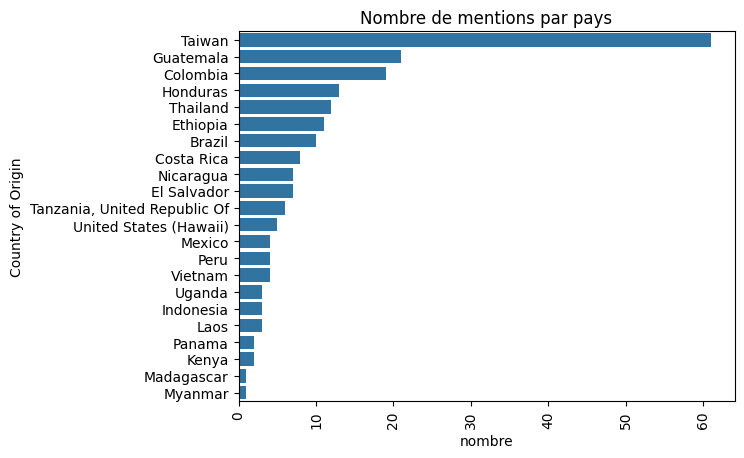

In [24]:
# Conservation que des deux premiers pays
pays_conserves = ["Taiwan", "Guatemala"]

# Remplacer les autres pays par 'other' => cumuler leurs valeurs pour avoir plus de poids
df['Country of Origin'] = df['Country of Origin'].apply(lambda x: x if x in pays_conserves else 'Other')

# Création du graphique
sns.barplot(x='count', y='Country of Origin', data=country_counts)
plt.xlabel('nombre')
plt.ylabel('Country of Origin')
plt.title('Nombre de mentions par pays')
plt.xticks(rotation=90)
plt.show()

In [25]:
# Comptage des mentions de chaque pays
country_counts = df['Country of Origin'].value_counts().reset_index()
country_counts.columns = ['Country of Origin', 'count']

# Affichage des résultats
print(country_counts)

  Country of Origin  count
0             Other    125
1            Taiwan     61
2         Guatemala     21


In [26]:
# Affichage de la matrice des corrélations
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

newdf = df.select_dtypes(include=numerics)
newdf.iloc[:,range(3,13)].corr()**2
# Représente le coefficient de détermination (R²) entre les variables
# R² = 0.676964 signifie que 67.70% de la variance de la variable "Aroma" peut être expliquée par la variable "Flavor", et vice versa.

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Uniformity,Clean Cup,Sweetness,Overall
Aroma,1.000000,0.676964,0.629480,0.508255,0.400816,0.555991,0.000788,NaN,NaN,0.642827
Flavor,0.676964,1.000000,0.768798,0.657614,0.547389,0.725539,0.001581,NaN,NaN,0.770619
Aftertaste,0.629480,0.768798,1.000000,0.663310,0.545640,0.742959,0.000572,NaN,NaN,0.749284
Acidity,0.508255,0.657614,0.663310,1.000000,0.585507,0.648404,0.003914,NaN,NaN,0.706579
Body,0.400816,0.547389,0.545640,0.585507,1.000000,0.666016,0.001928,NaN,NaN,0.595378
Balance,0.555991,0.725539,0.742959,0.648404,0.666016,1.000000,0.007932,NaN,NaN,0.782282
Uniformity,0.000788,0.001581,0.000572,0.003914,0.001928,0.007932,1.000000,NaN,NaN,0.005565
Clean Cup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sweetness,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Overall,0.642827,0.770619,0.749284,0.706579,0.595378,0.782282,0.005565,NaN,NaN,1.000000


In [27]:
# Détecter les valeurs manquantes (nulles) dans un DataFrame Pandas
df.isnull().any()

Unnamed: 0               False
ID                       False
Country of Origin        False
Farm Name                 True
Lot Number                True
Mill                      True
ICO Number                True
Company                  False
Altitude                  True
Region                    True
Producer                  True
Number of Bags           False
Bag Weight               False
In-Country Partner       False
Harvest Year             False
Grading Date             False
Owner                    False
Variety                   True
Status                   False
Processing Method         True
Aroma                    False
Flavor                   False
Aftertaste               False
Acidity                  False
Body                     False
Balance                  False
Uniformity               False
Clean Cup                False
Sweetness                False
Overall                  False
Defects                  False
Total Cup Points         False
Moisture

In [28]:
# Définir les features + le x & y
features_list = ["Aroma", "Flavor", "Aftertaste", "Acidity","Body","Balance","Category Two Defects","Quakers"] # composantes de x
x = df.loc[:,features_list]
y = df.loc[:,"Country of Origin"]

In [29]:
# diviser les données en ensembles d'entraînement et de test.
# fonction "train_test_split" de la bibliothèque sklearn
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size=0.2, 
                                                    random_state=42, 
                                            
                                                    stratify=y)

In [30]:
x_train

,Aroma,Flavor,Aftertaste,Acidity,Body,Balance,Category Two Defects,Quakers
107,7.83,7.83,7.67,7.58,7.58,7.58,1,1
3,8.08,8.17,8.17,8.25,8.17,8.08,0,0
203,7.33,7.08,6.75,7.17,7.42,7.17,12,2
100,7.83,7.67,7.50,7.92,7.50,7.67,12,0
24,7.83,8.00,7.92,8.00,8.00,7.92,0,0
...,...,...,...,...,...,...,...,...
30,8.00,8.00,7.83,7.83,7.75,7.92,0,0
12,8.08,8.00,8.08,8.08,8.00,8.00,0,0
144,7.67,7.58,7.50,7.50,7.58,7.50,4,0
20,8.00,7.92,8.08,7.92,7.75,8.00,0,0


In [31]:
# instantier la random forest
# modèle de classification et de regression : modèle d'ensemble, combinaison de prédictions de plusieurs modèles
# prédiction plus robuste et plus précise
# prédire la probabilité qu'un échantillon appartienne à une certaine classe ou la moyenne des prédictions de tous les arbres individuels
random_forest =  RandomForestClassifier(n_estimators=100, random_state=42)

# n_estimators spécifie le nombre d’arbres de décision dans la forêt
# random_state fixe la graine du générateur de nombres aléatoires pour assurer la reproductibilité des résultats

# entraine le random forest sur x_train et y_train
random_forest.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [32]:
# Calculer et afficher le score d'entraînement
train_score = random_forest.score(x_train, y_train)
print(f'Score sur les données du train : {train_score * 100:.2f}%')

Score sur les données du train : 100.00%


In [33]:
# Faire des prédictions sur les données de test
y_pred = random_forest.predict(x_test)

# Évaluer les performances du modèle
accuracy = accuracy_score(y_test, y_pred)
print(f'Précision du modèle: {accuracy * 100:.2f}%')

Précision du modèle: 78.57%


## Ici il y a Overfitting, il faut en sortir

In [36]:
# Définir la grille des hyperparamètres à rechercher
param_grid = {
    'n_estimators': [100, 200, 250],  # Essayez différents nombres d'arbres
    'max_depth': [10, 20, 30],  # Essayez différentes profondeurs d'arbre
    'min_samples_split': [5, 12, 20],  # Essayez différents nombres d'échantillons pour la division
    'min_samples_leaf': [4, 5, 8]  # Essayez différents nombres d'échantillons pour les feuilles
}

# Créer un modèle RandomForestClassifier
random_forest2 = RandomForestClassifier(random_state=42)

# Recherche des meilleurs hyperparamètres avec la validation croisée
grid_search = GridSearchCV(estimator=random_forest2, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(x_train, y_train)

# Afficher les meilleurs hyperparamètres
print("Meilleurs hyperparamètres :", grid_search.best_params_)

# Utiliser les meilleurs hyperparamètres pour créer un nouveau modèle
best_model = grid_search.best_estimator_

# Entraîner le modèle avec les meilleurs hyperparamètres
best_model.fit(x_train, y_train)

# Score d'entraînement avec les meilleurs hyperparamètres
train_score = best_model.score(x_train, y_train)
print(f'Score sur les données du train : {train_score * 100:.2f}%')

# Faire des prédictions sur l'ensemble de test
y_pred = best_model.predict(x_test)

# Calculer la précision avec les meilleurs hyperparamètres
accuracy = accuracy_score(y_test, y_pred)
print(f'Précision du modèle: {accuracy * 100:.2f}%')

Meilleurs hyperparamètres : {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 20, 'n_estimators': 200}
Score sur les données du train : 75.15%
Précision du modèle: 66.67%
